In [1]:
from measurer import Measurer

import json
import matplotlib.pyplot as plt
import pandas as pd
import os

from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("yhavinga/gpt2-medium-dutch")
model = GPT2LMHeadModel.from_pretrained("yhavinga/gpt2-medium-dutch")

In [3]:
# All measures combined with method of extracting unigram probabilities
measures = [
    "unigram_lp",
    "LogProb",
    "Mean LP",
    "Norm LP (Div)",
    "Norm LP (Sub)",
    "SLOR",
    "Word LP Min-1",
    "Word LP Min-2",
    "Word LP Min-3",
    "Word LP Min-4",
    "Word LP Min-5",
    "Word LP Mean",
    "Word LP Mean-Q1",
    "Word LP Mean-Q2",
    "Word LP Mean Sq"
]

methods = ["freq", "iso", "aoc"]

# All measures (including sentence length and unigram log probabilities)
all_measures = ["sent_len"] + [method + ":" + measure for method in methods for measure in measures]

# Measures to evaluate on
measures = [method + ":" + measure for method in methods for measure in measures[1:]]

# Measures per method
freq_measures = [measure for measure in measures if measure.startswith("freq")]
iso_measures = [measure for measure in measures if measure.startswith("iso")]
aoc_measures = [measure for measure in measures if measure.startswith("aoc")]

# Measures to analyze further on
a_measures = freq_measures + ["aoc:Norm LP (Sub)"]

In [4]:
measurer = Measurer(model, tokenizer)

## Dutch CoLA

In [5]:
train = load_dataset("GroNLP/dutch-cola", split="train")
# test = load_dataset("GroNLP/dutch-cola", split="validation")
test = load_dataset("GroNLP/dutch-cola", split="test")

train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [6]:
# Balance data
train_unacceptable = train[train["Acceptability"] == 0]
train_acceptable = train[train["Acceptability"] == 1].sample(
    len(train_unacceptable), random_state=8
)

train = pd.concat([train_acceptable, train_unacceptable])

In [7]:
# Example
example = pd.DataFrame()
example["Sentence"] = ["Jan eet hele van die taarten."]
example[all_measures] = measurer.get_measures("Jan eet hele van die taarten.", print_info=True)

table = pd.DataFrame(columns=methods)

for measure in measures:
    method, m = measure.split(":")
    table.loc[m, method] = str(round(example[measure].values[0], 2))

table.T.to_latex("results/example.tex")
table.T

Sentence length: 6

                LP         Unigram LP (freq)  Unigram LP (iso)   Unigram LP (aoc)  
 eet            -10.7794   -9.8275            -11.7341           -4.6667           
 hele           -7.6248    -8.1485            -10.9826           -4.0152           
 van            -9.3478    -3.9561            -3.2979            -1.2710           
 die            -6.0021    -5.3984            -5.5272            -2.6507           
 taarten        -6.0865    -12.4753           -13.6276           -4.6394           
.               -2.2240    -3.1185            -2.2106            -0.8729           
Total           -42.0646   -42.9243           -47.3799           -18.1158          


,LogProb,Mean LP,Norm LP (Div),Norm LP (Sub),SLOR,Word LP Min-1,Word LP Min-2,Word LP Min-3,Word LP Min-4,Word LP Min-5,Word LP Mean,Word LP Mean-Q1,Word LP Mean-Q2,Word LP Mean Sq
freq,-42.06,-7.01,-0.98,0.86,0.14,-2.36,-1.11,-1.1,-0.94,-0.71,-1.12,-2.36,-1.52,-1.61
iso,-42.06,-7.01,-0.89,5.32,0.89,-2.83,-1.09,-1.01,-0.92,-0.69,-1.16,-2.83,-1.64,-1.96
aoc,-42.06,-7.01,-2.32,-23.95,-3.99,-7.35,-2.55,-2.31,-2.26,-1.9,-2.95,-7.35,-4.07,-12.73


In [8]:
# Measure all sentences in the training set, needed for finding thresholds
tqdm.pandas()
train[all_measures] = train["Sentence"].progress_apply(measurer.get_measures).apply(pd.Series)

train.head()

100%|██████████| 14578/14578 [26:44<00:00,  9.08it/s]


,Source,Original ID,Acceptability,Original annotation,Sentence,Material added,sent_len,freq:unigram_lp,freq:LogProb,freq:Mean LP,...,aoc:SLOR,aoc:Word LP Min-1,aoc:Word LP Min-2,aoc:Word LP Min-3,aoc:Word LP Min-4,aoc:Word LP Min-5,aoc:Word LP Mean,aoc:Word LP Mean-Q1,aoc:Word LP Mean-Q2,aoc:Word LP Mean Sq
12449,SoD-Verb1,2.313b,1,None,Hij vertelde over onze twijfel of het huis ooi...,1,12.0,-93.402041,-54.376560,-4.531380,...,-1.284539,-2.620793,-2.307340,-1.939540,-1.622184,-1.448300,-1.337931,-2.289224,-1.872393,-2.261071
2652,SoD-Noun1,2.280b,1,None,Behandelen door een arts kost veel tijd.,0,9.0,-65.607125,-30.009590,-3.334399,...,-0.741976,-1.910203,-1.885132,-1.777839,-1.049925,-0.952435,-1.184251,-1.897667,-1.655775,-1.645478
9453,SoD-Adp,1.391d,1,None,Jan is niet helemaal goed bij zijn verstand.,0,8.0,-50.383784,-27.925176,-3.490647,...,-0.609734,-2.456448,-1.532235,-1.325067,-1.288143,-1.120451,-1.272576,-1.994341,-1.650473,-1.905354
15479,SoD-Coord,1.383b,1,None,Jan is ziek of hij is op vakantie.,0,8.0,-48.466850,-28.420625,-3.552578,...,-1.297653,-2.456448,-2.451499,-1.927814,-1.658265,-1.430894,-1.512279,-2.453973,-2.123506,-2.788995
4231,SoD-Noun1,1.225f,1,None,Zelfs in moeilijke tijden bleef ze haar vriend...,1,9.0,-71.959827,-27.168884,-3.018765,...,0.549064,-1.233286,-1.223873,-1.113905,-1.103691,-1.063467,-0.879080,-1.228579,-1.168689,-0.920192


In [9]:
# Find the best threshold for each measure
def find_threshold(measure):
    possible_thresholds = []
    for i in range(1000):
        threshold = train[measure].quantile(i / 1000)

        tp = len(train[(train[measure] > threshold) & (train["Acceptability"] == 1)])
        tn = len(train[(train[measure] <= threshold) & (train["Acceptability"] == 0)])

        acc = (tp + tn) / len(train)
        possible_thresholds.append((threshold, acc))

    best_threshold = max(possible_thresholds, key=lambda x: x[1])[0]
    return best_threshold


if "thresholds.json" in os.listdir():
    with open("thresholds.json", "r") as f:
        thresholds = json.load(f)
else:
    thresholds = {measure: find_threshold(measure) for measure in measures}
    with open("thresholds.json", "w") as f:
        json.dump(thresholds, f)

In [10]:
# Measure all sentences in the test set, needed for evaluation
tqdm.pandas()
test[all_measures] = test["Sentence"].progress_apply(measurer.get_measures).apply(pd.Series)

test.head()

100%|██████████| 2400/2400 [04:37<00:00,  8.66it/s]


,Source,Original ID,Acceptability,Original annotation,Sentence,Material added,sent_len,freq:unigram_lp,freq:LogProb,freq:Mean LP,...,aoc:SLOR,aoc:Word LP Min-1,aoc:Word LP Min-2,aoc:Word LP Min-3,aoc:Word LP Min-4,aoc:Word LP Min-5,aoc:Word LP Mean,aoc:Word LP Mean-Q1,aoc:Word LP Mean-Q2,aoc:Word LP Mean Sq
0,SoD-Noun2,5.189a,1,None,Jan heeft het kind in de armen.,0,7.0,-40.755502,-26.856314,-3.836616,...,-1.539349,-4.128883,-4.103656,-1.873357,-1.558840,-1.302243,-2.079125,-4.128883,-3.368632,-6.157677
1,SoD-Adp,1.293b,1,None,Jan legde het boek van de tafel af.,0,8.0,-51.338011,-38.120149,-4.765019,...,-2.128255,-2.732126,-2.208734,-1.998650,-1.830162,-1.650886,-1.826670,-2.470430,-2.192418,-3.539139
2,SoD-Adj,4.86a,1,None,Jan heeft evenveel mensen uitgenodigd als hij ...,0,11.0,-87.092331,-41.537589,-3.776144,...,-0.505282,-1.873357,-1.828723,-1.487967,-1.480803,-1.194776,-1.030233,-1.851040,-1.573125,-1.396811
3,SoD-Coord,1.305a,1,None,Dat Jan ziek is en dat Els afwezig is is een v...,0,13.0,-95.372741,-59.211629,-4.554741,...,-1.011928,-2.644752,-2.183327,-1.966191,-1.420465,-1.339588,-1.247057,-2.264757,-1.803067,-1.968960
4,SoD-Adj,2.25b,1,None,Oud genoeg voor de disco is Marie nog niet.,0,9.0,-60.736893,-47.138662,-5.237629,...,-2.393481,-2.784803,-2.685920,-2.374188,-1.849847,-1.780603,-1.791687,-2.735361,-2.423689,-3.664080


In [11]:
# Accuracy of each measure per method of extracting unigram probabilities
scores = pd.DataFrame(columns=methods)

for measure in measures:
    test[measure + "_pred"] = test[measure] > thresholds[measure]

    acc = len(test[(test[measure + "_pred"] == test["Acceptability"])]) / len(test)

    method, measure = measure.split(":")
    scores.loc[measure, method] = str(round(acc * 100, 1))

scores.to_latex("results/scores.tex")
scores

,freq,iso,aoc
LogProb,59.3,59.3,59.3
Mean LP,61.8,61.8,61.8
Norm LP (Div),61.6,61.3,60.2
Norm LP (Sub),56.2,55.5,65.1
SLOR,61.6,60.6,61.6
Word LP Min-1,62.8,58.6,58.8
Word LP Min-2,62.4,58.8,61.0
Word LP Min-3,61.7,60.3,59.8
Word LP Min-4,60.9,60.4,59.9
Word LP Min-5,60.3,60.0,58.3


In [31]:
# Table of similarity between measures
similarities = pd.DataFrame()
for i, measure1 in enumerate(a_measures):
    for measure2 in a_measures[i + 1 :]:
        n_same = len(test[(test[measure1 + "_pred"] == test[measure2 + "_pred"])])
        sim = n_same / len(test)
        method1, m1 = measure1.split(":")
        method2, m2 = measure2.split(":")

        if method1 == "aoc":
            m1 = "aoc:" + m1
        if method2 == "aoc":
            m2 = "aoc:" + m2

        similarities.at[m1, m2] = str(
            round(sim * 100, 1)
        )

similarities.to_latex("results/similarities.tex")
similarities

,Mean LP,Norm LP (Div),Norm LP (Sub),SLOR,Word LP Min-1,Word LP Min-2,Word LP Min-3,Word LP Min-4,Word LP Min-5,Word LP Mean,Word LP Mean-Q1,Word LP Mean-Q2,Word LP Mean Sq,aoc:Norm LP (Sub)
LogProb,57.2,52.4,36.4,50.3,61.7,68.3,73.2,77.2,76.7,52.7,57.2,55.3,54.9,75.5
Mean LP,NaN,84.5,72.3,77.0,63.3,66.6,65.4,64.0,62.1,82.0,67.2,75.8,80.1,72.2
Norm LP (Div),NaN,NaN,82.2,92.3,66.1,69.0,65.8,64.5,61.7,89.4,71.1,81.2,86.3,71.0
Norm LP (Sub),NaN,NaN,NaN,83.4,58.8,58.3,51.9,51.5,49.0,77.2,63.9,72.1,74.2,55.5
SLOR,NaN,NaN,NaN,NaN,66.2,68.2,64.4,64.0,61.5,87.0,71.1,79.7,84.1,68.3
Word LP Min-1,NaN,NaN,NaN,NaN,NaN,74.2,64.0,64.2,60.5,68.4,88.8,77.5,75.4,69.4
Word LP Min-2,NaN,NaN,NaN,NaN,NaN,NaN,75.0,72.6,65.8,69.4,76.3,78.5,75.2,74.9
Word LP Min-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.6,72.0,67.4,64.3,70.8,71.0,77.2
Word LP Min-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.2,65.8,62.4,67.0,68.3,77.0
Word LP Min-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,58.0,61.1,64.0,72.7


In [33]:
# Accuracy per source
sources = [
    "SoD-Zw",
    "SoD-Noun1",
    "SoD-Noun2",
    "SoD-Adj",
    "SoD-Adp",
    "SoD-Verb1",
    "SoD-Verb2",
    "SoD-Verb3",
    "SoD-Coord",
]
scores_per_source = pd.DataFrame()
for source in sources:
    test_source = test[test["Source"] == source]
    for measure in a_measures:
        correct = len(
            test_source[
                (test_source[measure + "_pred"] == test_source["Acceptability"])
            ]
        )
        acc = correct / len(test_source)
        if measure != "aoc:Norm LP (Sub)":
            _, measure = measure.split(":")
        scores_per_source.at[measure, source] = str(round(acc * 100, 1))

scores_per_source.to_latex("results/scores_per_source.tex")
scores_per_source

,SoD-Zw,SoD-Noun1,SoD-Noun2,SoD-Adj,SoD-Adp,SoD-Verb1,SoD-Verb2,SoD-Verb3,SoD-Coord
LogProb,40.7,68.2,54.4,62.0,55.4,59.9,56.9,65.9,57.6
Mean LP,47.8,58.0,62.6,64.0,58.1,64.7,69.4,61.1,62.7
Norm LP (Div),55.8,54.8,62.9,61.0,62.2,61.6,71.3,62.9,62.7
Norm LP (Sub),68.1,45.2,60.1,54.7,61.0,51.6,61.6,55.0,60.8
SLOR,60.2,54.8,65.7,59.4,64.0,59.2,70.8,63.8,58.2
Word LP Min-1,54.9,59.6,64.6,62.7,61.8,61.2,65.3,70.3,62.0
Word LP Min-2,53.1,60.2,62.6,61.4,63.3,65.7,64.4,66.8,59.5
Word LP Min-3,44.2,67.5,60.6,62.0,62.2,61.9,63.4,67.2,52.5
Word LP Min-4,46.9,64.6,60.9,61.6,59.9,61.6,63.9,63.8,53.8
Word LP Min-5,51.3,65.3,55.8,63.1,59.2,57.4,67.6,62.4,53.2


In [14]:
# Sentences wrongly classified by all measures
wrong = test.copy()
wrong["n_wrong"] = 0
for measure in measures:
    wrong["n_wrong"] += (wrong[measure + "_pred"] != wrong["Acceptability"]).astype(int)

wrong = wrong[wrong["n_wrong"] == len(measures)]

for sent in wrong[["Source", "Original ID", "Sentence", "Acceptability"]].values:
    print(sent)

['SoD-Verb2' '5.447a' 'Marie schreef jan hem dat boek toe te sturen.' 1]
['SoD-Adp' '3.14b' 'Recht staat Jan tussen de agenten.' 1]
['SoD-Adp' '2.45b' 'De eieren zijn voor er in.' 1]
['SoD-Adp' '2.31b' 'Jan reed de auto tot er voor aan toe.' 1]
['SoD-Adp' '4.12c' 'Marie heeft over ruimtevaart een boek gelezen.' 1]
['SoD-Noun2' '5.110a' 'Ober, twee bier, alstublieft.' 1]
['SoD-Verb1' '1.292b' 'Marie stuurt dat boek misschien wel.' 1]
['SoD-Adp' '1.310a' 'De stenen liggen van hier tot de heg.' 1]
['SoD-Verb3' '11.71b' 'Vertel eens op, dat verhaal!' 1]
['SoD-Adj' '4.163b' 'Op één na het best is Jan.' 1]
['SoD-Adj' "4.3b'" 'Deze tafel is even rond als die daar.' 1]
['SoD-Noun2' '4.252a' 'Wat zouden hem nou voor een boeken bevallen?' 1]
['SoD-Verb2' '5.296b' 'Jan heeft je weet wel over wie geroddeld.' 1]
['SoD-Adp' '1.82c' 'De koekjes zijn voor daar bij.' 1]
['SoD-Adp' '4.35a' 'De berg reed Jan op niet de brug.' 1]
['SoD-Adp' '1.332b' 'De hond speelt en hij doet dat boven.' 1]
['SoD-Adp' '1

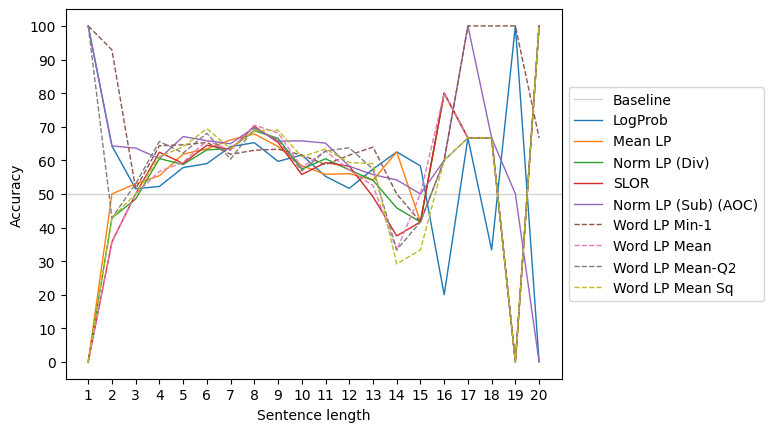

In [28]:
# Plot of accuracy per sentence length
accs_per_sent_len = {}
for sent_len in test["sent_len"].unique():
    if sent_len > 25:
        continue
    for measure in a_measures:
        correct = len(
            test[
                (test[measure + "_pred"] == test["Acceptability"])
                & (test["sent_len"] == sent_len)
            ]
        )
        acc = correct / len(test[test["sent_len"] == sent_len]) * 100
        accs_per_sent_len[(sent_len, measure)] = acc

accs_per_sent_len = pd.Series(accs_per_sent_len).unstack()

word_level_measures = [
    "freq:" + measure for measure in ["LogProb", "Mean LP", "Norm LP (Div)", "SLOR"]
] + ["aoc:Norm LP (Sub)"]
sent_level_measures = [
    "freq:" + measure
    for measure in ["Word LP Min-1", "Word LP Mean", "Word LP Mean-Q2", "Word LP Mean Sq"]
]
linestyle_map = {}
for measure in sent_level_measures:
    linestyle_map[measure] = "--"
for measure in word_level_measures:
    linestyle_map[measure] = "-"

fig, ax = plt.subplots()
plt.axhline(y=50, color="lightgrey", label="Baseline", linewidth=1)
for measure in word_level_measures + sent_level_measures:
    label = measure.split(":")[1]
    if measure == "aoc:Norm LP (Sub)":
        label = "Norm LP (Sub) (AOC)"
    ax.plot(
        accs_per_sent_len.index,
        accs_per_sent_len[measure],
        label=label,
        linewidth=1,
        linestyle=linestyle_map[measure],
    )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(range(1, 21))
plt.yticks(range(0, 110, 10))
plt.xlabel("Sentence length")
plt.ylabel("Accuracy")

plt.savefig("results/accs_per_sent_len.png", bbox_inches="tight")
plt.show()

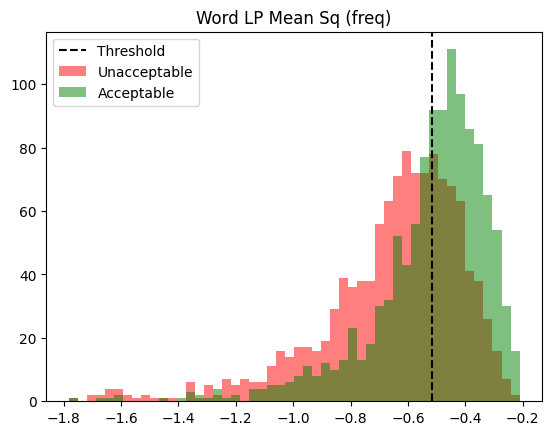

<Figure size 640x480 with 0 Axes>

In [29]:
# Histogram for all measures showing distribution of acceptable and unacceptable sentences
# and the threshold
for measure in measures:
    r = (test[measure].quantile(0.01), test[measure].quantile(0.99))
    plt.hist(
        test.loc[test["Acceptability"] == 0, measure],
        color="red",
        alpha=0.5,
        range=r,
        bins=50,
    )
    plt.hist(
        test.loc[test["Acceptability"] == 1, measure],
        color="green",
        alpha=0.5,
        range=r,
        bins=50,
    )

    plt.axvline(thresholds[measure], color="black", linestyle="--")

    method, m = measure.split(":")
    plt.title(m + " (" + method + ")")
    plt.legend(["Threshold", "Unacceptable", "Acceptable"])
    plt.savefig(f"results/histograms/hist_{measure}.png", bbox_inches="tight")
    if measure == "freq:Word LP Mean Sq":
        plt.show()
    plt.clf()

## BLiMP-NL

In [17]:
datasets = []
for dataset in sorted(os.listdir("BLiMP-NL/BLiMP-NL (large)")):
    dataset = pd.read_csv(f"BLiMP-NL/BLiMP-NL (large)/{dataset}")
    datasets.append(dataset)

In [18]:
tqdm.pandas()
for data in datasets:
    print(data.loc[0, "Phenomenon"])
    data[all_measures] = (
        data["Sentence"].progress_apply(measurer.get_measures).apply(pd.Series)
    )

Anaphor agreement


100%|██████████| 400/400 [00:51<00:00,  7.79it/s]


Verb Second


100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


Wh-Movement


100%|██████████| 1200/1200 [02:38<00:00,  7.59it/s]


Wh-Movement Restrictions


100%|██████████| 1200/1200 [02:31<00:00,  7.90it/s]


Relativization


100%|██████████| 600/600 [01:19<00:00,  7.50it/s]


Topicalization


100%|██████████| 800/800 [01:45<00:00,  7.61it/s]


Parasitic Gaps


100%|██████████| 800/800 [01:47<00:00,  7.46it/s]


R-Words


100%|██████████| 400/400 [00:57<00:00,  6.90it/s]


Nominalization


100%|██████████| 400/400 [00:55<00:00,  7.20it/s]


Determiners


100%|██████████| 800/800 [01:36<00:00,  8.26it/s]


Quantifiers


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Binding (Principle A)


100%|██████████| 400/400 [00:44<00:00,  8.90it/s]


Adpositional Phrases


100%|██████████| 400/400 [00:47<00:00,  8.34it/s]


Crossing Dependencies


100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


Extraposition


100%|██████████| 600/600 [01:17<00:00,  7.75it/s]


Argument Structure


100%|██████████| 1600/1600 [03:21<00:00,  7.93it/s]


Complementive


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


Passive


100%|██████████| 800/800 [01:38<00:00,  8.15it/s]


Infinitival Argument Clause


100%|██████████| 1800/1800 [03:38<00:00,  8.24it/s]


Finite Argument Clause


100%|██████████| 1200/1200 [02:30<00:00,  7.95it/s]


Auxiliaries


100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]


Adverbial Modification


100%|██████████| 400/400 [00:46<00:00,  8.62it/s]


In [39]:
# Scores on BLiMP-NL per phenomenon
blimp_scores = pd.DataFrame()

total_len = sum(len(data["Item"].unique()) for data in datasets)
correct_per_measure = {measure.split(":")[1]: 0 for measure in a_measures}
correct_per_measure["aoc:Norm LP (Sub)"] = 0
for data in datasets:
    phenomenon = data.loc[0, "Phenomenon"]
    for measure in a_measures:
        correct = 0
        for item in data["Item"].unique():
            acceptable_score = data[(data["Item"] == item) & (data["Acceptability"] == "Acceptable")][measure].item()
            unacceptable_score = data[(data["Item"] == item) & (data["Acceptability"] == "Unacceptable")][measure].item()
            correct += (acceptable_score > unacceptable_score)
        acc = correct / len(data["Item"].unique())
        if measure != "aoc:Norm LP (Sub)":
            _, measure = measure.split(":")
        blimp_scores.loc[phenomenon, measure] = str(round(acc * 100, 1))
        correct_per_measure[measure] += correct

for measure in a_measures:
    if measure != "aoc:Norm LP (Sub)":
        _, measure = measure.split(":")
    correct = correct_per_measure[measure]
    acc = correct / total_len
    blimp_scores.loc["Total", measure] = str(round(acc * 100, 1))

blimp_scores.to_latex("results/blimp_scores.tex")
blimp_scores